In [40]:
import imblearn
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from ff_custom_scripts import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
# import catboost as cb
from catboost import CatBoostClassifier, Pool, cv, CatBoostRegressor
# import gridsearchcv
from sklearn.model_selection import GridSearchCV


In [41]:
train, test,leaderboard,holdout = load_files(nanvalues='keep')

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1210) (294, 1210) (530, 1210) (1111, 1210)


In [42]:
def get_weights(df,target):
    weights = df[target].value_counts(normalize=True)
    w1 = weights[0].round(2)
    w2 = weights[1].round(2)
    return [w2, w1]

get_weights(train,'eviction')

[0.06, 0.94]

# Model

In [43]:
def run_model(train, test, target='gpa', classifier=False):

    catcols = train.select_dtypes(include=['category']).columns
    train[catcols] = train[catcols].astype(str)
    test[catcols] = test[catcols].astype(str)

    X_train, y_train = prepare_data(train, target)
    X_test, y_test = prepare_data(test, target)

    print(X_train.shape, y_train.shape)

    numerical_features = cols_per_type(X_train, 'Continuous')
    print(f'N. of numerical features: {len(numerical_features)}')
    ordinal_features = cols_per_type(X_train, 'Ordered Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    print(f'N. of binary features: {len(binary_features)}')
    categorical_features = cols_per_type(X_train, 'Unordered Categorical')
    print(f'N. of categorical features: {len(categorical_features)}')
    print(f'N. of ordinal features: {len(ordinal_features)}')
    
    iter = 20_000

    if classifier:
        # score = 'neg_brier_score'
        catboost = CatBoostClassifier(
            thread_count=-1, cat_features=categorical_features, verbose=0,random_seed=88,class_weights=get_weights(train,target))
    else:
        
        catboost = CatBoostRegressor(thread_count=-1, cat_features=categorical_features, random_seed=88, 
                                     iterations=iter, early_stopping_rounds=iter*0.1,verbose=10)

    #     score = 'neg_mean_squared_error'

    # param_grid = {
    #     'learning_rate': [0.005, 0.02],
    #     'depth': [4, 8],
    #     'l2_leaf_reg': [2, 3],
    #     'bagging_temperature': [0.5, 1],
    # }

    # model = BayesSearchCV(catboost, param_grid, cv=5, n_jobs=-1, scoring=score, verbose=20,
    #                        n_iter=10).fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=0)
    
    model = catboost.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=0)

    return model


def mse_error(model, data, target='gpa'):
    X, y = prepare_data(data, target)
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

# GPA

In [44]:
gpa_model = run_model(train,test,target='gpa', classifier=False)

(929, 1204) (929,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [45]:
mse_error(gpa_model, test, target='gpa')

0.3953156309294618

In [46]:
mse_error(gpa_model, leaderboard, target='gpa')

0.381353768793594

# Material Hardship

In [47]:
model_materialHardship = run_model(train,test, target='materialHardship', classifier=False)

(1167, 1204) (1167,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [48]:
mse_error(model_materialHardship, test, target='materialHardship')

0.019935158005541707

In [49]:
mse_error(model_materialHardship, leaderboard, target='materialHardship')

0.024591579104201622

# Grit


In [50]:
model_grit = run_model(train,test, target='grit', classifier=False)

(1134, 1204) (1134,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [51]:
mse_error(model_grit, test, target='grit')

0.2142759524687608

In [52]:
mse_error(model_grit, leaderboard, target='grit')

0.22869351329090482

# Eviction

In [53]:
model_eviction = run_model(train,test,target='eviction', classifier=True)

(1167, 1204) (1167,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [54]:
score_model(model_eviction, target='eviction',test=test, leaderboard=leaderboard, classifier=True, holdout=None)

Scores without threshold adjusment
Test Brier: 0.1610
Test F1: 0.2034
Leaderboard Brier: 0.1377
Number of positive predictions: 55.0
>> Leaderboard F1: 0.1412
Leaderboard Accuracy: 0.8623
Leaderboard Recall: 0.2000


Scores with threshold adjusment


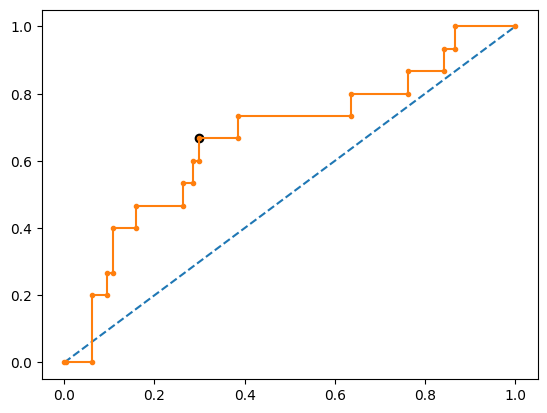

Threshold=0.464, FPR=0.300, TPR=0.667
Test brier: 0.305
Test F1: 0.168
Leaderboard Brier: 0.264
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84       500
         1.0       0.11      0.53      0.19        30

    accuracy                           0.74       530
   macro avg       0.54      0.64      0.51       530
weighted avg       0.92      0.74      0.81       530

Leaderboard F1: 0.186


In [55]:
score_classifier(model_eviction, target='eviction', holdout=None, test=test,leaderboard=leaderboard)

# jobTraining

In [56]:
model_job = run_model(train,test,target='jobTraining', classifier=True)

(1169, 1204) (1169,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [57]:
score_model(model_job, target='jobTraining',test=test, leaderboard=leaderboard, classifier=True, holdout=None)

Scores without threshold adjusment
Test Brier: 0.2432
Test F1: 0.4662
Leaderboard Brier: 0.3340
Number of positive predictions: 116.0
>> Leaderboard F1: 0.3270
Leaderboard Accuracy: 0.6660
Leaderboard Recall: 0.2925


Scores with threshold adjusment


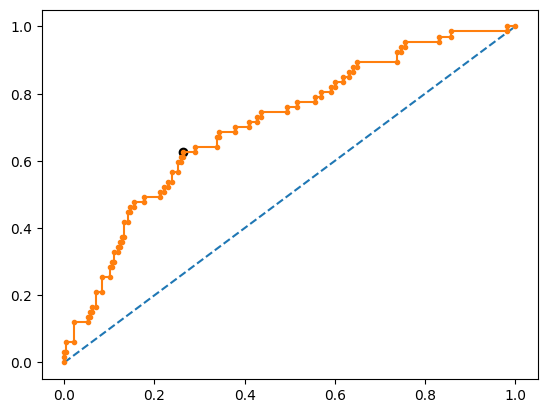

Threshold=0.453, FPR=0.262, TPR=0.627
Test brier: 0.291
Test F1: 0.491
Leaderboard Brier: 0.392
              precision    recall  f1-score   support

         0.0       0.75      0.68      0.72       383
         1.0       0.33      0.41      0.37       147

    accuracy                           0.61       530
   macro avg       0.54      0.55      0.54       530
weighted avg       0.63      0.61      0.62       530

Leaderboard F1: 0.366


In [58]:
score_classifier(model_job, target='jobTraining', holdout=None, test=test,leaderboard=leaderboard)

# Layoff

In [59]:
model_layoff = run_model(train, test, target='layoff', classifier=True)

(1026, 1204) (1026,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [60]:
score_model(model_layoff, target='layoff',test=test, leaderboard=leaderboard, classifier=True, holdout=None)

Scores without threshold adjusment
Test Brier: 0.4104
Test F1: 0.2797
Leaderboard Brier: 0.4038
Number of positive predictions: 191.0
>> Leaderboard F1: 0.3097
Leaderboard Accuracy: 0.5962
Leaderboard Recall: 0.4034


Scores with threshold adjusment


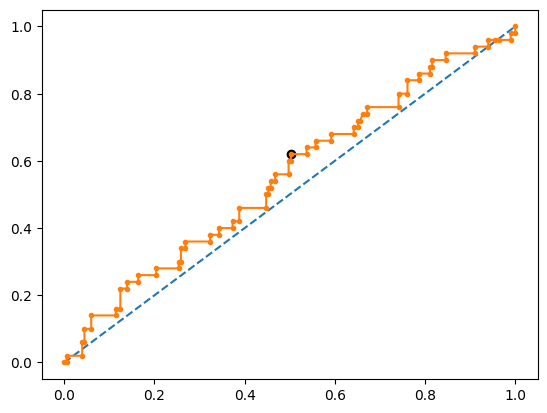

Threshold=0.495, FPR=0.502, TPR=0.620
Test brier: 0.482
Test F1: 0.331
Leaderboard Brier: 0.453
              precision    recall  f1-score   support

         0.0       0.80      0.55      0.65       411
         1.0       0.26      0.53      0.34       119

    accuracy                           0.55       530
   macro avg       0.53      0.54      0.50       530
weighted avg       0.68      0.55      0.58       530

Leaderboard F1: 0.344


In [61]:
score_classifier(model_layoff, target='layoff', holdout=None, test=test,leaderboard=leaderboard)